##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="seaquest"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 5

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

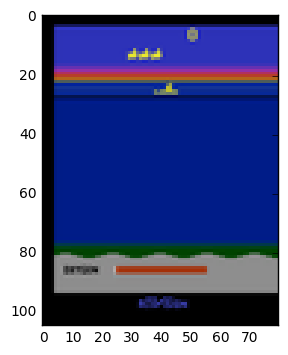

In [3]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

In [4]:
atari.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

0.0 False {}


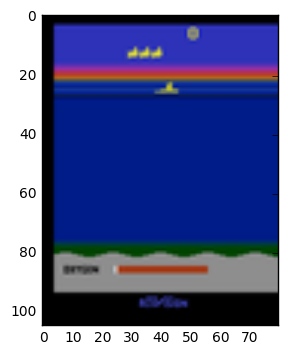

In [5]:
x = atari.step(0)
print(x[1], x[2], x[3])
plt.imshow(x[0])

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [6]:
import lasagne
import theano

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [7]:
from lasagne.layers import InputLayer, DimshuffleLayer, ReshapeLayer
from lasagne.layers import FeaturePoolLayer
from agentnet.memory import GRUCell, WindowAugmentation

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))
grayscale_observation_layer = FeaturePoolLayer(observation_layer, pool_size=3, axis=3, pool_function=theano.tensor.mean)
print(grayscale_observation_layer.output_shape)

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(grayscale_observation_layer,(0,3,1,2))
observation_reshape = ReshapeLayer(observation_reshape, shape=([0], [2], [3]))
print(observation_reshape.output_shape)


windows_state = InputLayer( (None,3,IMAGE_W, IMAGE_H) )

new_window_state = WindowAugmentation(observation_reshape, windows_state)
print(new_window_state.output_shape)
memory_dict = {new_window_state: windows_state}

(None, 105, 80, 1)
(None, 105, 80)
(None, 3, 105, 80)


In [8]:
from lasagne.layers import Conv2DLayer, Pool2DLayer, DenseLayer, batch_norm, dropout, FlattenLayer
nn = new_window_state

nn = Conv2DLayer(nn, 16, filter_size=(8, 8), stride=(4, 4))
nn = Conv2DLayer(nn, 32, filter_size=(4, 4), stride=(2, 2))
nn = FlattenLayer(nn)
nn = DenseLayer(nn, 256)

#please set this to your last layer for convenience
last_layer = nn

In [9]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [10]:
#from agentnet.target_network import TargetNetwork
#target_network = TargetNetwork([qvalues_layer, action_layer])
#target_qvalues_layer, target_action_layer = target_network.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [11]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer,
              agent_states=memory_dict)

#agent_target = Agent(observation_layers=observation_layer,
#                     policy_estimators=target_qvalues_layer,
#                     action_layers=target_action_layer)

In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, q-evaluator layer.W, q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [13]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE)


In [14]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE'
  'UPLEFTFIRE' 'UPLEFTFIRE']
 ['UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE' 'UPLEFTFIRE'
  'UPLEFTFIRE' 'UPLEFTFIRE']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 200 ms, sys: 4 ms, total: 204 ms
Wall time: 204 ms


In [15]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [16]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)

#_,_,_,_,qvalues_seq_target = agent_target.get_sessions(
#    replay,
#    session_length=SEQ_LENGTH,
#    optimize_experience_replay=True,
#)

In [17]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      #Qvalues_target=qvalues_seq_target,
                                                     )

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [18]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights)

In [19]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [20]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-28 17:19:24,477] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 17:19:24,478] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 17:19:24,502] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.0.22010.video000000.mp4
[2016-10-28 17:20:03,035] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 10001 timesteps with reward=0.0


In [ ]:
from IPython.display import HTML

video_path="./records/openaigym.video.0.18519.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

#the loop may take eons to finish.
#consider interrupting early.
for i in range(10**10):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    for i in range(5):
        loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = np.maximum(0.5 - 3e-4 * epoch_counter, 0.1)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        print("Load target weights")
        #target_network.load_weights()

        action_layer.epsilon.set_value(0.001)
        rewards[epoch_counter] = pool.evaluate(record_video=True)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=10	epsilon=0.497	reward/step=0.00000
iter=20	epsilon=0.494	reward/step=0.00000


In [ ]:
print(1)

# Evaluating results
 * Here we plot learning curves and sample testimonials

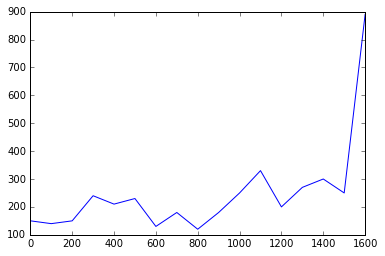

In [23]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [26]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

[2016-10-19 05:01:32,554] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 05:01:32,555] Clearing 1 monitor files from previous run (because force=True was provided)


Episode finished after 1030 timesteps with reward=250.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1175 timesteps with reward=270.0
!
Episode finished after 1103 timesteps with reward=290.0
!
Episode finished after 1325 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1125 timesteps with reward=230.0
!
Episode finished after 1322 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=320.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1204 timesteps with reward=300.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finish

[2016-10-19 05:04:18,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1340 timesteps with reward=280.0
mean session score=279.000000.5


In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__